# (Homework) Week 6 - DataScience Bootcamp Fall 2025

All solution cells are replaced with `# TODO` placeholders so you can fill them in.

**Name:** \
**Email:**

---

### Problem 1: Dataset Splitting

1. You have recordings of 44 phones from 100 people; each person records ~200 phones/day for 5 days.
   - Design a valid training/validation/test split strategy that ensures the model generalizes to **new speakers**.

2. You now receive an additional dataset of 10,000 phone recordings from **Kilian**, a single speaker.
   - You must train a model that performs well **specifically for Kilian**, while also maintaining generalization.

*Describe your proposed split strategy and reasoning.* (Theory)

To make sure the model learns to handle new speakers, the dataset should be split by speaker so that no person appears in more than one split. A simple setup is to use 80 speakers for training, 10 for validation, and 10 for testing, keeping all five days of each speaker’s recordings in the same group. This prevents the model from memorizing voices and forces it to learn phone patterns that work for new people. When you get the extra 10,000 recordings from Kilian, you keep the original split as it is so you can still measure generalization to new speakers, and then create a separate split inside Kilian’s data, for example training on his first few days, validating on day four, and testing on day five. The model is trained on the multi speaker training set plus Kilian’s training recordings, and you check performance on both the unseen speaker validation set and the Kilian validation set to make sure improvements for Kilian do not hurt general performance. In the end you report results on the unseen speaker test set and on the Kilian test set to show how well the model works in both cases.

### Problem 2: K-Nearest Neighbors

1. **1-NN Classification:** Given dataset:

   Positive: (1,2), (1,4), (5,4)

   Negative: (3,1), (3,2)

   Plot the 1-NN decision boundary and classify new points visually.

2. **Feature Scaling:** Consider dataset:

   Positive: (100,2), (100,4), (500,4)

   Negative: (300,1), (300,2)

   What would the 1-NN classify point (500,1) as **before and after scaling** to [0,1] per feature?

3. **Handling Missing Values:** How can you modify K-NN to handle missing features in a test point?

4. **High-dimensional Data:** Why can K-NN still work well for images even with thousands of pixels?


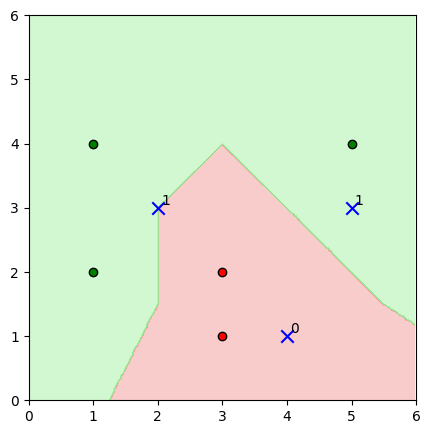

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier

X = np.array([[1,2],[1,4],[5,4],[3,1],[3,2]])
y = np.array([1,1,1,0,0])

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)

h = 0.02
x_min, x_max = 0, 6
y_min, y_max = 0, 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(5,5))
plt.contourf(xx, yy, Z, cmap=ListedColormap(["lightcoral","lightgreen"]), alpha=0.4)
plt.scatter(X[y==1,0], X[y==1,1], c="green", edgecolor="k")
plt.scatter(X[y==0,0], X[y==0,1], c="red", edgecolor="k")

new_points = np.array([[2,3],[4,1],[5,3]])
new_labels = clf.predict(new_points)
plt.scatter(new_points[:,0], new_points[:,1], c="blue", marker="x", s=80)

for p, lab in zip(new_points, new_labels):
    plt.text(p[0]+0.05, p[1]+0.05, str(lab))

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [7]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

X = np.array([[100,2],[100,4],[500,4],[300,1],[300,2]])
y = np.array([1,1,1,0,0])
q = np.array([[500,1]])

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)
print("Before scaling:", clf.predict(q)[0])

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
q_scaled = scaler.transform(q)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_scaled, y)
print("After scaling:", clf.predict(q_scaled)[0])

Before scaling: 1
After scaling: 0


Handling missing features in K-NN

If a test point has missing values, you can change the distance so that it only uses the features that are present. For each training point, you compare it to the test point only on the coordinates where the test point is not missing, and compute the distance on that subset. You can also divide by the number of used features so distances are on a similar scale. Then you pick the nearest neighbors using these masked distances. Another option is to fill missing values first, then run normal K-NN.

Why K-NN can still work for images with many pixels

Even though images have thousands of pixels, real images are not random points. They have strong structure and lie on a much lower dimensional manifold. Images of the same object or digit tend to cluster together and are closer to each other than to very different images. Also, in practice we usually do K-NN not on raw pixels but on features from a model, like a CNN embedding. In that feature space, similar images are even closer and K-NN can work well despite the high raw dimension.

### Problem 3: Part 1

You are given a fully trained Perceptron model with weight vector **w**, along with training set **D_TR** and test set **D_TE**.

1. Your co-worker suggests evaluating $h(x) = sign(w \cdot x)$ for every $(x, y)$ in D_TR and D_TE. Does this help determine whether test error is higher than training error?
2. Why is there no need to compute training error explicitly for the Perceptron algorithm?

Checking the perceptron predictions on the training set does not tell you anything useful. When the perceptron finishes training, it has already reached a point where it makes no mistakes on the training set. The algorithm only updates the weights when it sees a wrong prediction. If it stops updating, that means there are no wrong predictions left. So the training error is zero without needing to compute it again.

The test error must still be computed on the test set, since the model has never seen those examples. But the training error does not need to be calculated because the perceptron guarantees it is zero at the end of training.

### Problem 3: Two-point 2D Dataset (Part 2)

Run the Perceptron algorithm **by hand or in code** on the following data:

1. Positive class: (10, -2)
2. Negative class: (12, 2)

Start with $w_0 = (0, 0)$ and a learning rate of 1.

- Compute how many updates are required until convergence.
- Write down the sequence of $w_i$ vectors.

In [8]:
X = np.array([[10, -2],
              [12,  2]], dtype=float)
y = np.array([1, -1], dtype=int)

w = np.zeros(2, dtype=float)
eta = 1.0

weights = [w.copy()]
updates = 0

converged = False
while not converged:
    converged = True
    for i in range(len(X)):
        if y[i] * np.dot(w, X[i]) <= 0:
            w = w + eta * y[i] * X[i]
            updates += 1
            weights.append(w.copy())
            converged = False

print("updates:", updates)
print("weights:")
for i, wi in enumerate(weights):
    print("w{} = {}".format(i, wi))


updates: 9
weights:
w0 = [0. 0.]
w1 = [10. -2.]
w2 = [-2. -4.]
w3 = [ 8. -6.]
w4 = [-4. -8.]
w5 = [  6. -10.]
w6 = [ -6. -12.]
w7 = [  4. -14.]
w8 = [ -8. -16.]
w9 = [  2. -18.]


### Problem 4: Reconstructing the Weight Vector

Given the log of Perceptron updates:

| x | y | count |
|---|---|--------|
| (0, 0, 0, 0, 4) | +1 | 2 |
| (0, 0, 6, 5, 0) | +1 | 1 |
| (3, 0, 0, 0, 0) | -1 | 1 |
| (0, 9, 3, 6, 0) | -1 | 1 |
| (0, 1, 0, 2, 5) | -1 | 1 |

Assume learning rate = 1 and initial weight $w_0 = (0, 0, 0, 0, 0)$.

Compute the final weight vector after all updates.

In [9]:
import numpy as np

X = np.array([
    [0,0,0,0,4],
    [0,0,6,5,0],
    [3,0,0,0,0],
    [0,9,3,6,0],
    [0,1,0,2,5]
], dtype=float)

y = np.array([+1, +1, -1, -1, -1])
count = np.array([2,1,1,1,1])

w = np.zeros(5, dtype=float)

for xi, yi, ci in zip(X, y, count):
    for _ in range(ci):
        w = w + yi * xi

print(w)

[ -3. -10.   3.  -3.   3.]


### Problem 5: Visualizing Perceptron Convergence

Implement a Perceptron on a small 2D dataset with positive and negative examples.

- Plot the data points.
- After each update, visualize the decision boundary.
- Show how it converges to a stable separator.

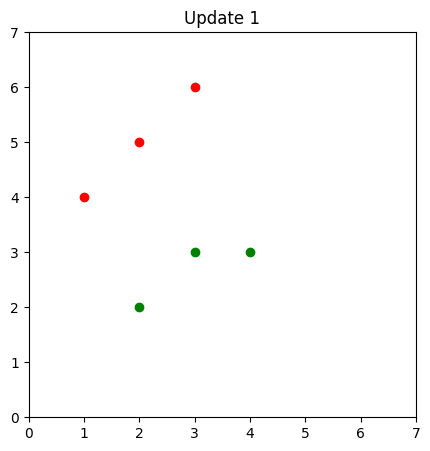

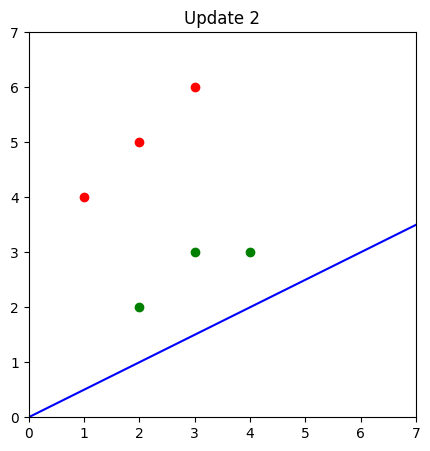

/tmp/ipython-input-2154648757.py:21: RuntimeWarning: divide by zero encountered in divide
  ys = -(w[0]*xs + b) / w[1]


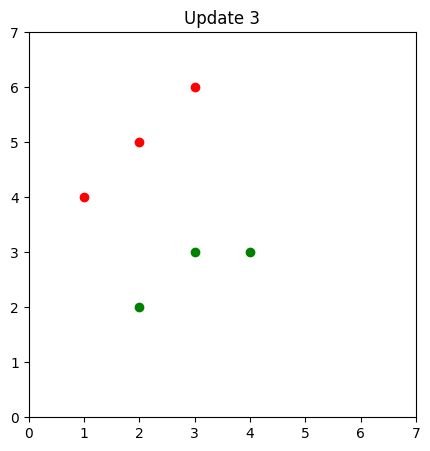

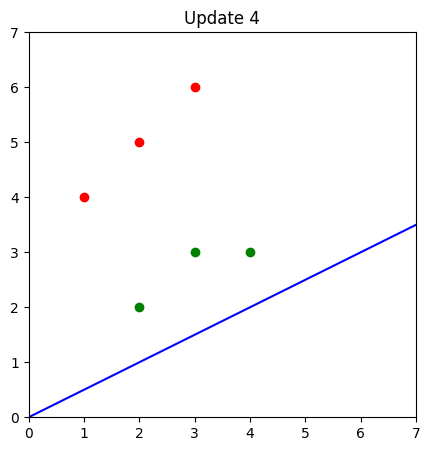

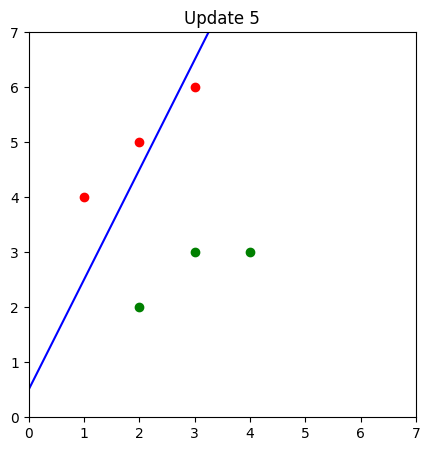

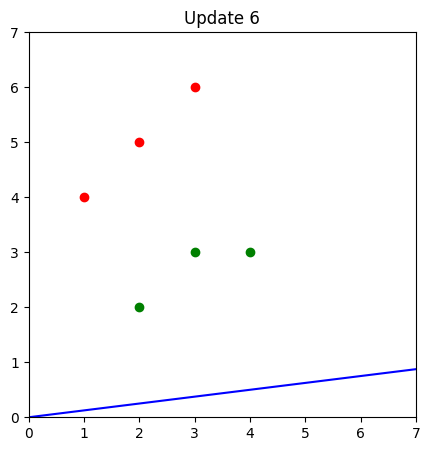

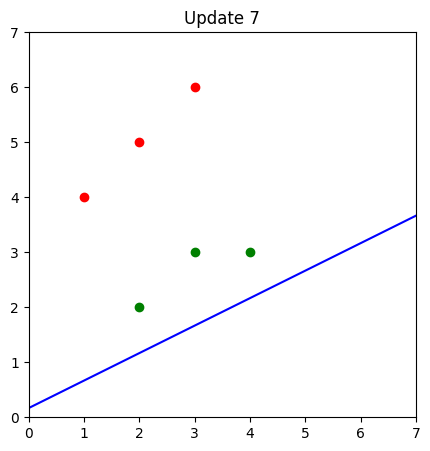

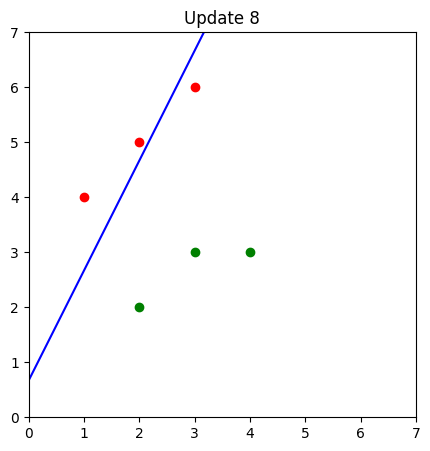

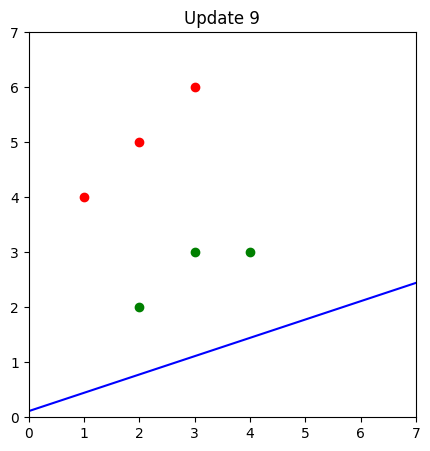

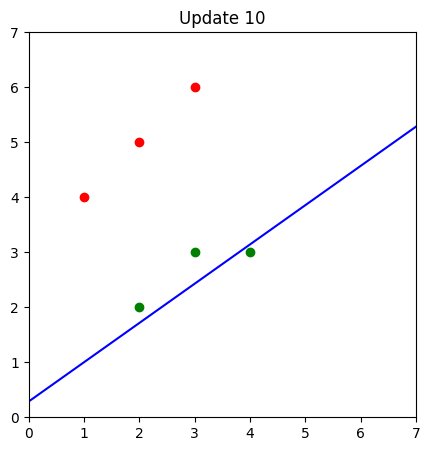

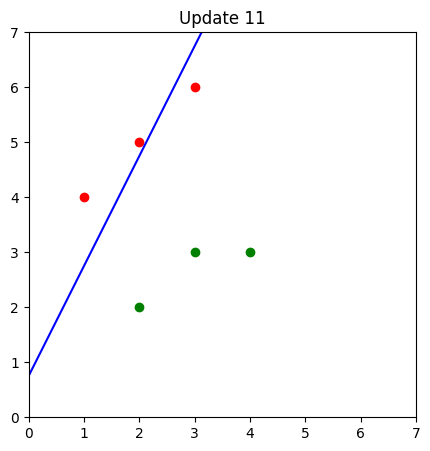

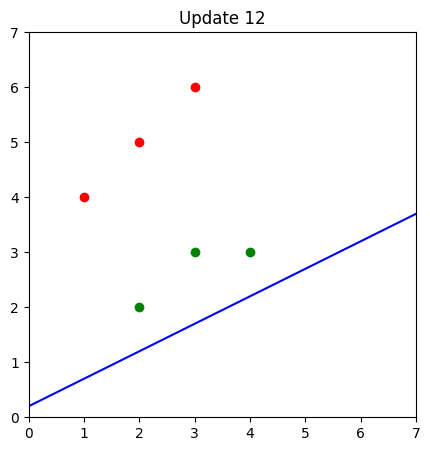

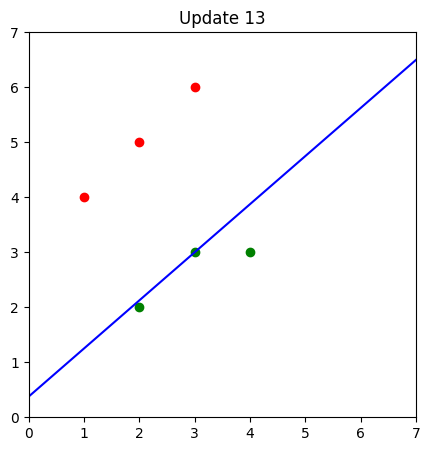

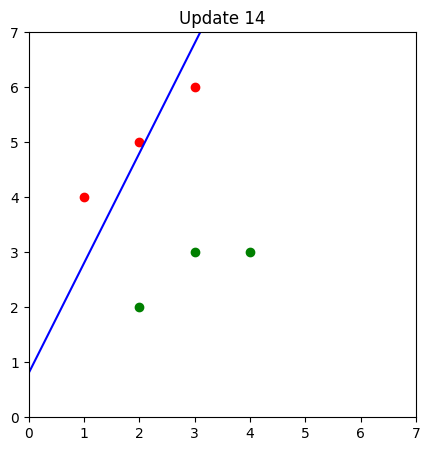

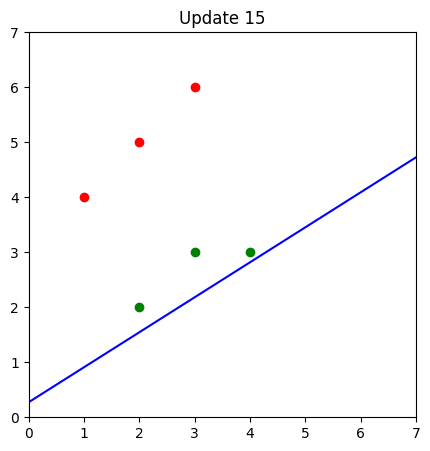

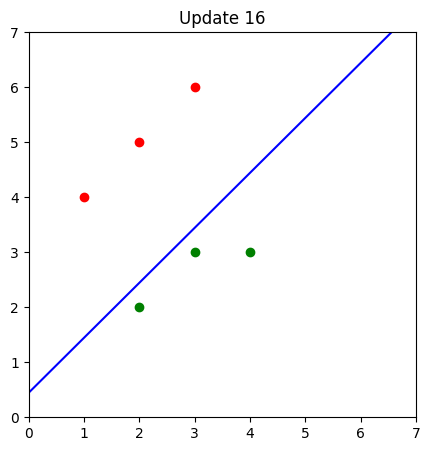

final w: [ 9. -9.]
final b: 4


In [11]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array([
    [2,2],
    [3,3],
    [4,3],
    [1,4],
    [2,5],
    [3,6]
])

y = np.array([1,1,1,-1,-1,-1])

w = np.zeros(2)
b = 0
eta = 1

def plot_boundary(w, b, X, y, step):
    xs = np.linspace(0,7,100)
    ys = -(w[0]*xs + b) / w[1]
    plt.figure(figsize=(5,5))
    plt.scatter(X[y==1,0], X[y==1,1], c="green")
    plt.scatter(X[y==-1,0], X[y==-1,1], c="red")
    plt.plot(xs, ys, 'b-')
    plt.xlim(0,7)
    plt.ylim(0,7)
    plt.title(f"Update {step}")
    plt.show()

step = 0
changed = True

while changed:
    changed = False
    for i in range(len(X)):
        if y[i] * (np.dot(w, X[i]) + b) <= 0:
            w = w + eta * y[i] * X[i]
            b = b + eta * y[i]
            step += 1
            plot_boundary(w, b, X, y, step)
            changed = True

print("final w:", w)
print("final b:", b)